# Tarea 1 INF 395

Para las tareas se utilizará `Keras`, una libreria de Deep Learning de alto nivel para Python, con el reciente anuncio de Keras Core, uno puede escoger el backend de su preferencia, ya sea Pytorch, Tensorflow o JAX.

Para más Información pueden revisar la documentación oficial de Keras: https://keras.io/

In [ ]:
#Para utilizar keras-core primero hay que instalar tensorflow o pytorch o jax
!pip install tensorflow

# una vez instalado nuestro backend podemos instalar keras-core
#Se recomienda correr el jupyter notebook en colab, ya que tiene acceso gratis a GPUS y también tiene ya instalado tensorflow, pytorch y jax, solo hace falta instalar keras-core.
!pip install -q keras-core

## Integrantes:

* Nombre: Diego Saa Bruna
* Nombre: Nicolás Castro
* Nombre: Matias Vargas

## Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
import seaborn as sns

# Aquí se escoge el backend de keras
os.environ["KERAS_BACKEND"] = "tensorflow" # 'torch', 'tensorflow', 'jax'

import keras_core as keras

SEED = 42
keras.utils.set_random_seed(SEED)

Using TensorFlow backend


## Helper Functions

In [ ]:
def viz_imgs(imgs, labels):
  "Función para visualizar imágenes junto a sus labels"
  plt.figure(figsize=(10,10))
  random_inds = np.random.choice(imgs.shape[0],36)
  for i in range(36):
      plt.subplot(6,6,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      image_ind = random_inds[i]
      plt.imshow(np.squeeze(imgs[image_ind]), cmap=plt.cm.binary)
      plt.xlabel(labels[image_ind])

In [ ]:
def plot_losses(history, loss):
  "Función para graficar la función de pérdida del modelo"
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Error Graph')
  plt.ylabel(loss.name)
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

In [ ]:
def plot_cm(y_pred, y_test):
  "Función para graficar matriz de confusión"
  cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
  cm_display = ConfusionMatrixDisplay(cm).plot()

## Parte 1: Demostración del uso de Keras

### 1.1 Mnist

Mnist es un dataset de imágenes de dígitos escritos a mano. Cada imagen es de 28x28 pixeles y está en escala de grises. El dataset está dividido en 60.000 imágenes de entrenamiento y 10.000 imágenes de testeo.

In [ ]:
#Cargamos el Dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


#### Exploración de los Datos

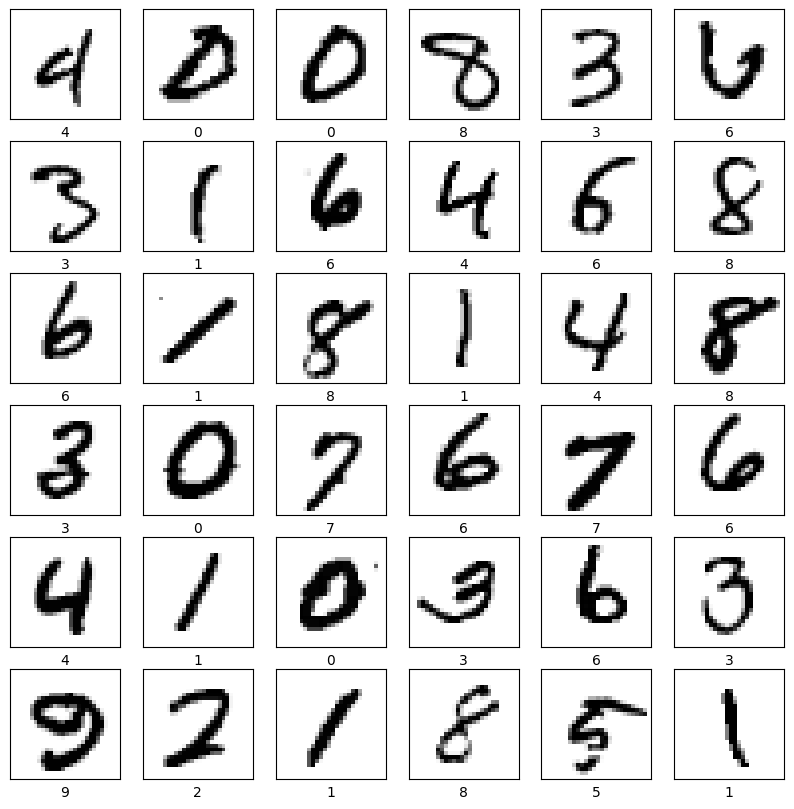

In [ ]:
# Visualizamos algunas imágenes y sus clases
viz_imgs(x_train, y_train)

In [ ]:
#Descripción de los datos
num_classes = len(np.unique(y_train))
input_shape = x_train.shape[1:]

print('cantidad de clases:', num_classes)
print('Dimension de los datos:', input_shape)

cantidad de clases: 10
Dimension de los datos: (28, 28)


#### One Hot Encoding

In [ ]:
# convertimos los vectores de clases a matrices binarias
print('antes:\n',y_train)

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print('\nDespues:\n',y_train)

antes:
 [5 0 4 ... 5 6 8]

Despues:
 [[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


#### Arquitectura de la red

In [ ]:
#Un modelo simple de redes neuronales FeedForward
inputs = keras.Input(shape=input_shape)
x = keras.layers.Flatten()(inputs)
x =  keras.layers.Dense(128, activation='relu')(x)
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten (Flatten)               │ (None, 784)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 128)               │    100,480 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_1 (Dense)                 │ (None, 10)                │      1,290 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

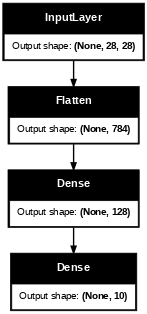

In [ ]:
keras.utils.plot_model(model, show_shapes=True, rankdir="TB", dpi=50)

#### Definición de hiperparámetros

In [ ]:
# definimos algunos hiperparámetros
batch_size = 128        #cantidad de imágenes por batch
epochs = 20             #cantidad de epochs
validation_split = 0.2  #Porcentaje de data destinada a validación

In [ ]:
#compilamos nuestro modelo, agregando la función de pérdida, el optimizador y las métricas
loss= keras.losses.CategoricalCrossentropy()
optimizer= keras.optimizers.SGD(learning_rate=1e-3)
metrics=["accuracy"]

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

#### Entrenamiento del Modelo

In [ ]:
#Entrenamos nuestro modelo
history = model.fit(x_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=validation_split,
                    verbose=1)

Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.6077 - loss: 17.2967 - val_accuracy: 0.7898 - val_loss: 1.0557
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7962 - loss: 0.9616 - val_accuracy: 0.8378 - val_loss: 0.7853
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8409 - loss: 0.6901 - val_accuracy: 0.8591 - val_loss: 0.6569
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8647 - loss: 0.5500 - val_accuracy: 0.8724 - val_loss: 0.5855
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8799 - loss: 0.4683 - val_accuracy: 0.8839 - val_loss: 0.5360
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8914 - loss: 0.4117 - val_accuracy: 0.8911 - val_loss: 0.5022
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9014 - loss: 0.3691 - val_accuracy: 0.8976 - val_loss: 0.4756
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9085 - loss: 0.3359 - val_accuracy:

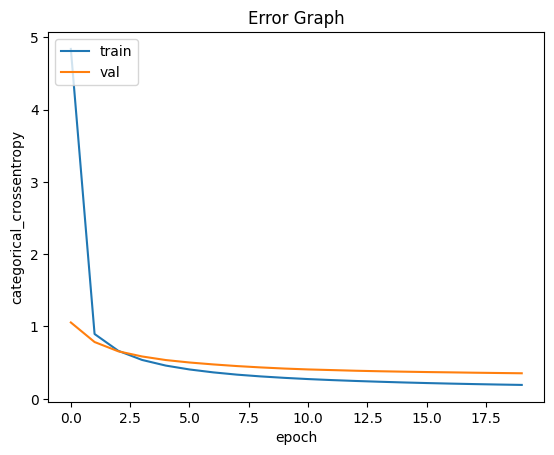

In [ ]:
plot_losses(history, loss)

#### Evaluación del Modelo

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.36804890632629395
Test accuracy: 0.9214000105857849


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


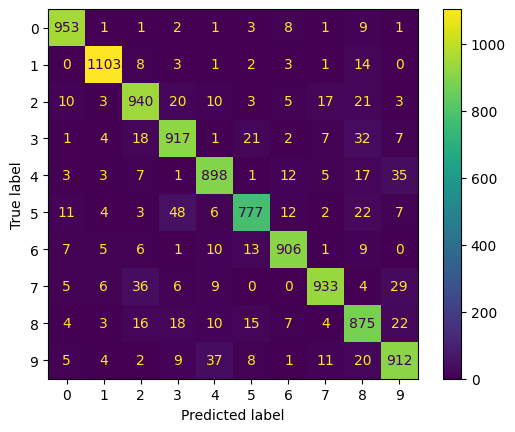

In [ ]:
# Graficamos la matriz de confusión
y_pred = model.predict(x_test)

plot_cm(y_pred, y_test)

### 1.2.1 Cifar10

Cifar10 es un dataset de imágenes de 32x32 pixeles, que contiene 10 clases distintas. Este dataset es muy utilizado para probar algoritmos de clasificación de imágenes. En este caso, utilizaremos una versión reducida de este dataset, que contiene 50000 imágenes de entrenamiento y 10000 imágenes de testeo, con 100 imágenes por clase. Las clases son: 'avión', 'automóvil', 'pájaro', 'gato', 'venado', 'perro', 'rana', 'caballo', 'barco' y 'camión'.

In [ ]:
#Cargamos el Dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
#Visualizamos si el dataset es balanceado o no.
pd.value_counts(pd.Series(y_train.reshape(-1)))

6    5000
9    5000
4    5000
1    5000
2    5000
7    5000
8    5000
3    5000
5    5000
0    5000
dtype: int64

/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


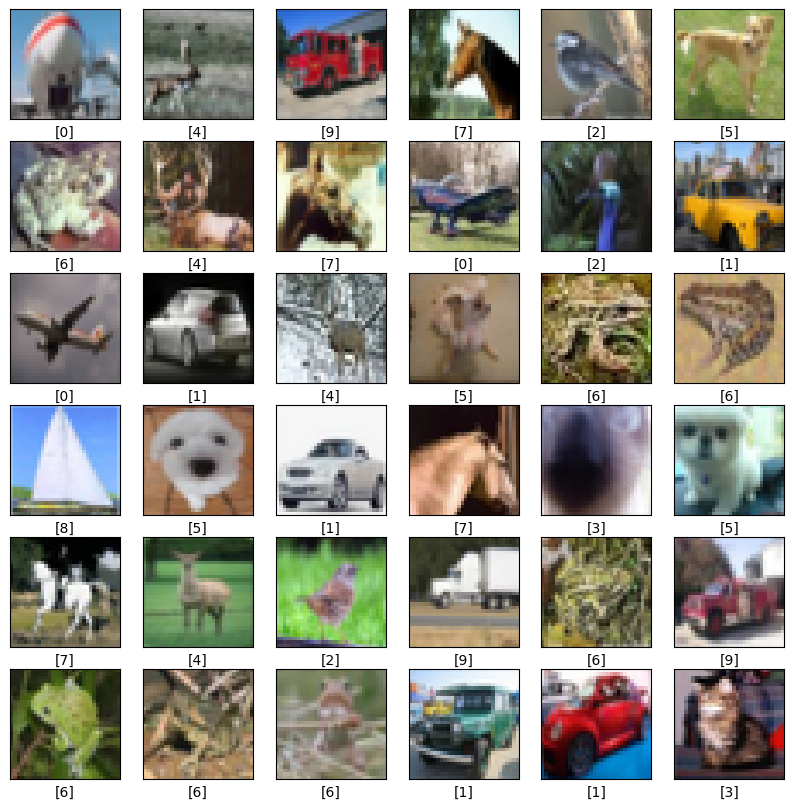

In [ ]:
# Visualizamos algunas imágenes y sus clases
viz_imgs(x_train, y_train)

In [ ]:
#Descripción de los datos
num_classes = len(np.unique(y_train))
input_shape = x_train.shape[1:]

print('cantidad de imágenes:',x_train.shape[0])
print('Dimensión de los datos:',input_shape)
print('Tipo de Datos:',x_train.dtype)
print('cantidad de clases:', num_classes)

cantidad de imágenes: 50000
Dimensión de los datos: (32, 32, 3)
Tipo de Datos: uint8
cantidad de clases: 10


In [ ]:
# convertimos los vectores de clases a matrices binarias
print('antes:\n', y_train)

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print('\nDespues:\n',y_train)

antes:
 [[6]
 [9]
 [9]
 ...
 [9]
 [1]
 [1]]

Despues:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


In [ ]:
#Un modelo simple de redes neuronales FeedForward
inputs = keras.Input(shape=input_shape)
x = keras.layers.Flatten()(inputs)
x =  keras.layers.Dense(128, activation='relu')(x)
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_1 (Flatten)             │ (None, 3072)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_2 (Dense)                 │ (None, 128)               │    393,344 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_3 (Dense)                 │ (None, 10)                │      1,290 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 394,634 (1.51 MB)

 Trainable params: 394,634 (1.51 MB)

 Non-trainable params: 0 (0.00 B)

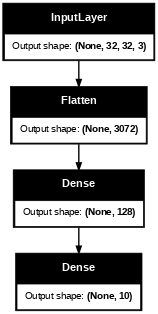

In [ ]:
keras.utils.plot_model(model, show_shapes=True, rankdir="TB", dpi=50)

In [ ]:
# definimos algunos hiperparámetros
batch_size = 128
epochs = 20
validation_split = 0.2

In [ ]:
#compilamos nuestro modelo, agregando la función de pérdida, el optimizador y las métricas
loss= keras.losses.CategoricalCrossentropy()
optimizer= keras.optimizers.SGD(learning_rate=1e-3)
metrics=["accuracy"]

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [ ]:
#Entrenamos nuestro modelo
history = model.fit(x_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=validation_split,
                    verbose=1)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.1021 - loss: 582.5866 - val_accuracy: 0.0953 - val_loss: 2.3144
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1018 - loss: 2.3032 - val_accuracy: 0.0953 - val_loss: 2.3126
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.1017 - loss: 2.3021 - val_accuracy: 0.0954 - val_loss: 2.3128
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.1019 - loss: 2.3018 - val_accuracy: 0.0954 - val_loss: 2.3130
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1019 - loss: 2.3017 - val_accuracy: 0.0954 - val_loss: 2.3131
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1019 - loss: 2.3017 - val_accuracy: 0.0954 - val_loss: 2.3131
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.1019 - loss: 2.3017 - val_accuracy: 0.0954 - val_loss: 2.3125
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.1019 - loss: 2.3017 - val_accuracy:

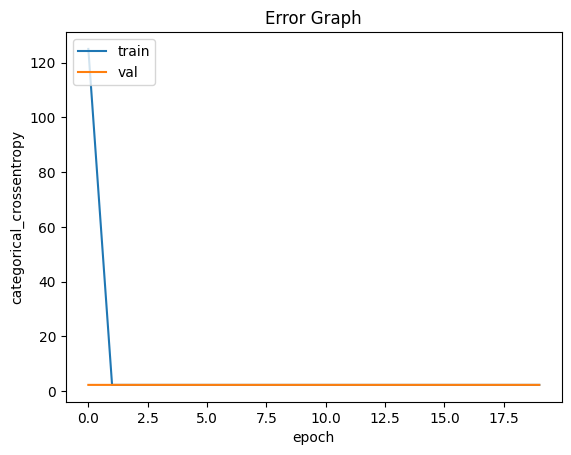

In [ ]:
plot_losses(history, loss)

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 2.309175729751587
Test accuracy: 0.09969999641180038


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


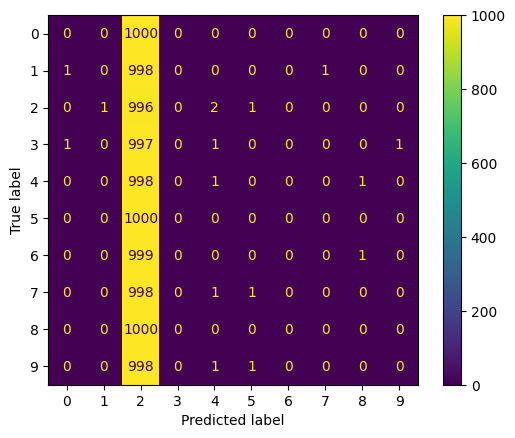

In [ ]:
# Graficamos la matriz de confusión
y_pred = model.predict(x_test)

plot_cm(y_pred, y_test)

In [ ]:
# Comparamos otras métricas de clasificación como la precisión, recall y f1-score
target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5', 'class 6', 'class 7', 'class 8', 'class 9']

print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.00      0.00      0.00      1000
     class 1       0.00      0.00      0.00      1000
     class 2       0.10      1.00      0.18      1000
     class 3       0.00      0.00      0.00      1000
     class 4       0.17      0.00      0.00      1000
     class 5       0.00      0.00      0.00      1000
     class 6       0.00      0.00      0.00      1000
     class 7       0.00      0.00      0.00      1000
     class 8       0.00      0.00      0.00      1000
     class 9       0.00      0.00      0.00      1000

    accuracy                           0.10     10000
   macro avg       0.03      0.10      0.02     10000
weighted avg       0.03      0.10      0.02     10000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Podemos observar como este simple modelo de redes neuronales no es lo suficientemente capaz de clasificar las imágenes, de hecho les asigna el mismo label a todas las imágenes.

Es por esto que saltan los warnings, porque al calcular f1, recall y precisión, no hay datos para las otras clases.

Ahora vamos a ver como podemos mejorar nuestro modelo.

### 1.2.2 Mejorando el Modelo

In [ ]:
#Es una práctica común en modelos de machine learning escalar nuestros datos, asi nos aseguramos de que todos tengan el mismo rango, con pequeños cambios como estos nuestros modelos pueden mejorar su desempeño.

#Escalamos las imágenes entre [0,1]
x_train = x_train / 255
x_test = x_test / 255

In [ ]:
# Agregamos capas de Dropout, inicializadores y hacemos el modelo más profundo
inputs = keras.Input(shape=input_shape)
x = keras.layers.Flatten()(inputs)
x =  keras.layers.Dense(512, activation='relu', kernel_initializer="he_normal")(x)
x = keras.layers.Dropout(0.1)(x)
x =  keras.layers.Dense(256, activation='relu', kernel_initializer="he_normal")(x)
x = keras.layers.Dropout(0.1)(x)
x =  keras.layers.Dense(128, activation='relu', kernel_initializer="he_normal")(x)
x = keras.layers.Dropout(0.1)(x)
x =  keras.layers.Dense(64, activation='relu', kernel_initializer="he_normal")(x)
x = keras.layers.Dropout(0.1)(x)
x =  keras.layers.Dense(32, activation='relu', kernel_initializer="he_normal")(x)
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32, 32, 3)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_2 (Flatten)             │ (None, 3072)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_4 (Dense)                 │ (None, 512)               │  1,573,376 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout (Dropout)               │ (None, 512)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_5 (Dense)                 │ (None, 256)               │    131,328 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_1 (Dropout)             │ (None, 256)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_6 (Dense)                 │ (None, 128)               │     32,896 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_2 (Dropout)             │ (None, 128)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_7 (Dense)                 │ (None, 64)                │      8,256 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_3 (Dropout)             │ (None, 64)                │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_8 (Dense)                 │ (None, 32)                │      2,080 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_9 (Dense)                 │ (None, 10)                │        330 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 1,748,266 (6.67 MB)

 Trainable params: 1,748,266 (6.67 MB)

 Non-trainable params: 0 (0.00 B)

**Explique cómo funciona la capa de Dropout dentro del modelo y por qué esta capa mejora las predicciones [3pts]**

`Respuesta:` El dropout es una técnica de regularización que ayuda a reducir el sobreajuste al desactivar aleatoriamente un porcentaje de neuronas pertenecientes a una capa oculta durante el entrenamiento. El valor 0.1 indica que alrededor del 10% de las neuronas se  desactivarán en esa capa oculta durante cada iteración del entrenamiento.

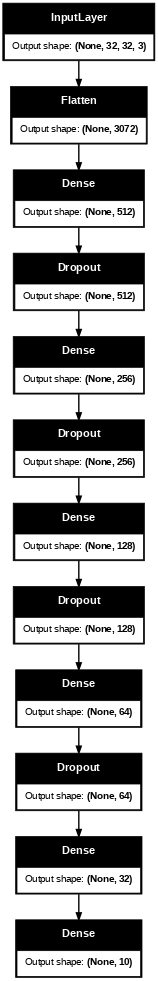

In [ ]:
from tensorflow.keras.utils import plot_model
keras.utils.plot_model(model, show_shapes=True, rankdir="TB", dpi=50)

In [ ]:
#Agregamos Callbacks
#Early Stopping monitorea la función de pérdida y detiene el entrenamiento cuando no hay mejora dentro de un número de épocas determinado, lo que nos ahorra tiempo de entrenamiento y también evita el sobreajuste.
my_callbacks = [
    keras.callbacks.EarlyStopping(
      monitor="val_loss",
      min_delta=0,
      patience=10,
      restore_best_weights=True #Es importante retornar los mejores pesos, por defecto viene en False asi que siempre asegurarse de ponerlo en True
    )
]

In [ ]:
#Cambiamos el Optimizador a Adam
loss= keras.losses.CategoricalCrossentropy()
optimizer= keras.optimizers.Adam(learning_rate=1e-3)
metrics=["accuracy"]

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [ ]:
# agregamos más epoochs ahora que tenemos early stopping
batch_size = 128
epochs = 200
validation_split = 0.2

In [ ]:
#Entrenamos nuestro modelo
history = model.fit(x_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=validation_split,
                    verbose=1,
                    callbacks=my_callbacks
                    )

Epoch 1/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - accuracy: 0.1602 - loss: 2.2486 - val_accuracy: 0.3037 - val_loss: 1.9452
Epoch 2/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.2929 - loss: 1.9177 - val_accuracy: 0.3428 - val_loss: 1.8358
Epoch 3/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.3310 - loss: 1.8321 - val_accuracy: 0.3723 - val_loss: 1.7465
Epoch 4/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.3514 - loss: 1.7836 - val_accuracy: 0.3762 - val_loss: 1.7440
Epoch 5/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.3663 - loss: 1.7460 - val_accuracy: 0.3991 - val_loss: 1.6826
Epoch 6/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.3885 - loss: 1.7047 - val_accuracy: 0.3926 - val_loss: 1.6943
Epoch 7/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3916 - loss: 1.6841 - val_accuracy: 0.4108 - val_loss: 1.6543
Epoch 8/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.3995 - loss: 1.6578 - val_ac

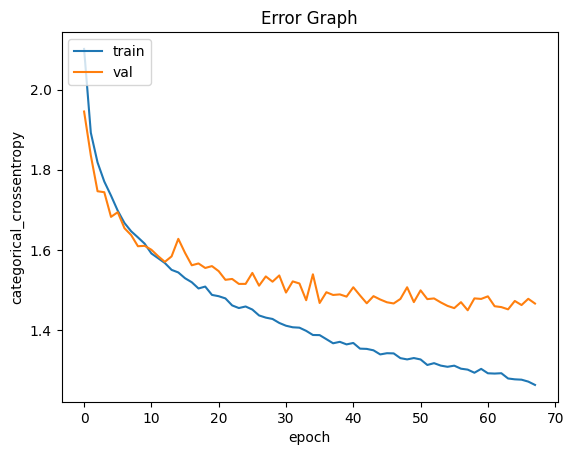

In [ ]:
plot_losses(history, loss)

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 1.4306927919387817
Test accuracy: 0.49309998750686646


Aún estamos con un accuracy del 0.5, eso seria equivalente a lanzar una moneda al aire y que salga cara o sello, por lo que no es un buen modelo, pero se puede mejorar.

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


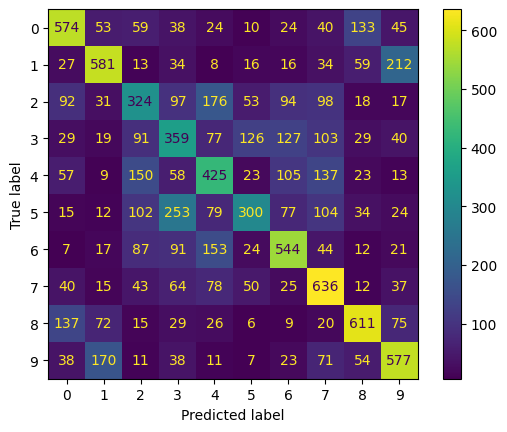

In [ ]:
y_pred = model.predict(x_test)

plot_cm(y_pred, y_test)

In [ ]:
target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5', 'class 6', 'class 7', 'class 8', 'class 9']

print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.56      0.57      0.57      1000
     class 1       0.59      0.58      0.59      1000
     class 2       0.36      0.32      0.34      1000
     class 3       0.34      0.36      0.35      1000
     class 4       0.40      0.42      0.41      1000
     class 5       0.49      0.30      0.37      1000
     class 6       0.52      0.54      0.53      1000
     class 7       0.49      0.64      0.56      1000
     class 8       0.62      0.61      0.62      1000
     class 9       0.54      0.58      0.56      1000

    accuracy                           0.49     10000
   macro avg       0.49      0.49      0.49     10000
weighted avg       0.49      0.49      0.49     10000



### 1.2.3 Último Modelo ahora Con Convoluciones y Skip Connections

Keras nos permite complejizar el modelo de una manera muy sencilla, agregaremos capas convolucionales, ya que estas son muy buenas a la hora de trabajar con imágenes, también agregaremos skip connections que son conexiones que se saltan capas del modelo.

**EJEMPLO DE SKIP CONNECTION**

<img src="https://theaisummer.com/static/8d19d048cd68d6dce362e025cf3b635a/1ac66/skip-connection.png">

**¿Qué problema resuelven las Skip Connections y como lo hacen? [3pts]**

`Respuesta:`

- Se suelen utilizar cuando la red comienza a perder presición en las capas más profundas, es decir, más capas no necesariamente implica un mejor resultado.
- Omite capas que no son capaces de aprender, mejorando el rendimiento.
- Permite que la información de las capas anteriores llegue directamente a las capas posteriores, sin ser atenuada ni transformada de manera excesiva. Esto es especialmente útil cuando las capas intermedias tienen dificultades para aprender información significativa.
- Ayuda a evitar el problema de desvanecimiento/explosión del gradiente al saltar capas del modelo.
- Permiten adaptar modelos pre entrenados, a través de conexiones entre capas preentrenadas y las nuevas.

In [ ]:
# Agregamos capas de Dropout, inicializadores y hacemos el modelo más profundo
inputs = keras.Input(shape=input_shape)
x_1 = keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer="he_normal")(inputs)
x_1 = keras.layers.BatchNormalization()(x_1)
x_1 = keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer="he_normal")(x_1)
x_1 = keras.layers.BatchNormalization()(x_1)
x_1 = keras.layers.MaxPooling2D(pool_size=(2,2))(x_1)
x_1 = keras.layers.Dropout(0.2)(x_1)
flatten_x1 = keras.layers.Flatten()(x_1)

x_2 = keras.layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer="he_normal")(x_1)
x_2 = keras.layers.BatchNormalization()(x_2)
x_2 = keras.layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer="he_normal")(x_2)
x_2 = keras.layers.BatchNormalization()(x_2)
x_2 = keras.layers.MaxPooling2D(pool_size=(2,2))(x_2)
x_2 = keras.layers.Dropout(0.2)(x_2)
flatten_x2 = keras.layers.Flatten()(x_2)

x_3 = keras.layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer="he_normal")(x_2)
x_3 = keras.layers.BatchNormalization()(x_3)
x_3 = keras.layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer="he_normal")(x_3)
x_3 = keras.layers.BatchNormalization()(x_3)
x_3 = keras.layers.MaxPooling2D(pool_size=(2,2))(x_3)
x_3 = keras.layers.Dropout(0.2)(x_3)
flatten_x3 = keras.layers.Flatten()(x_3)

z = keras.layers.concatenate([flatten_x1, flatten_x2])
z = keras.layers.concatenate([z, flatten_x3])

z =  keras.layers.Dense(512, activation='relu', kernel_initializer="he_normal")(z)
z = keras.layers.Dropout(0.1)(z)
z =  keras.layers.Dense(256, activation='relu', kernel_initializer="he_normal")(z)
z = keras.layers.Dropout(0.1)(z)
z =  keras.layers.Dense(128, activation='relu', kernel_initializer="he_normal")(z)
z = keras.layers.Dropout(0.1)(z)
z =  keras.layers.Dense(64, activation='relu', kernel_initializer="he_normal")(z)
z = keras.layers.Dropout(0.1)(z)
z =  keras.layers.Dense(32, activation='relu', kernel_initializer="he_normal")(z)
outputs = keras.layers.Dense(num_classes, activation='softmax')(z)

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 32, 32, 3) │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │     896 │ input_layer_3[0][0]  │
│                     │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalization │ (None, 32, 32,    │     128 │ conv2d[0][0]         │
│ (BatchNormalizatio… │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │   9,248 │ batch_normalization… │
│                     │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │     128 │ conv2d_1[0][0]       │
│ (BatchNormalizatio… │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ max_pooling2d       │ (None, 16, 16,    │       0 │ batch_normalization… │
│ (MaxPooling2D)      │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dropout_4 (Dropout) │ (None, 16, 16,    │       0 │ max_pooling2d[0][0]  │
│                     │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │  18,496 │ dropout_4[0][0]      │
│                     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │     256 │ conv2d_2[0][0]       │
│ (BatchNormalizatio… │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │  36,928 │ batch_normalization… │
│                     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │     256 │ conv2d_3[0][0]       │
│ (BatchNormalizatio… │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ max_pooling2d_1     │ (None, 8, 8, 64)  │       0 │ batch_normalization… │
│ (MaxPooling2D)      │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dropout_5 (Dropout) │ (None, 8, 8, 64)  │       0 │ max_pooling2d_1[0][… │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 8, 8, 128) │  73,856 │ dropout_5[0][0]      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 128) │     512 │ conv2d_4[0][0]       │
│ (BatchNormalizatio… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 8, 8, 128) │ 147,584 │ batch_normalization… │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 128) │     512 │ conv2d_5[0][0]       │
│ (BatchNormalizatio… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ max_pooling2d_2     │ (None, 4, 4, 128) │       0 │ batch_normalization

 Total params: 7,804,234 (29.77 MB)

 Trainable params: 7,803,338 (29.77 MB)

 Non-trainable params: 896 (3.50 KB)

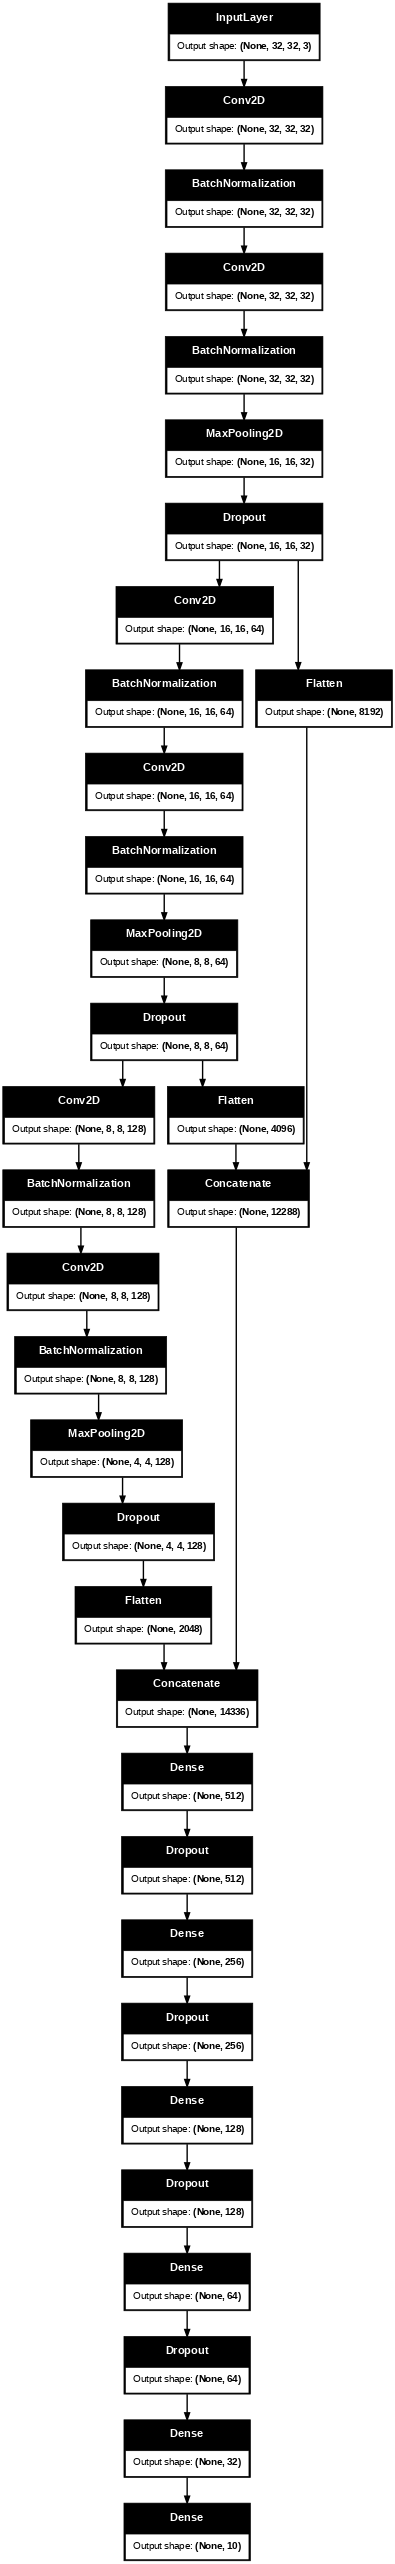

In [ ]:
keras.utils.plot_model(model, show_shapes=True, rankdir="TB", dpi=50)

In [ ]:
#Cambiamos el Optimizador a AdamW
loss= keras.losses.CategoricalCrossentropy()
optimizer= keras.optimizers.AdamW(learning_rate=1e-3)
metrics=["accuracy"]

model.compile(loss=loss, optimizer=optimizer, metrics=metrics, jit_compile=True)

In [ ]:
#Early Stopping
my_callbacks = [
    keras.callbacks.EarlyStopping(
      monitor="val_loss",
      min_delta=0,
      patience=10,
      restore_best_weights=True #Es importante retornar los mejores pesos, por defecto viene en False asi que siempre asegurarse de ponerlo en True
    )
]

In [ ]:
# Hiperparámetros
batch_size = 128
epochs = 200
validation_split = 0.2

In [ ]:
#Entrenamos nuestro modelo
history = model.fit(x_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=validation_split,
                    verbose=1,
                    callbacks=my_callbacks
                    )

Epoch 1/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 43s 67ms/step - accuracy: 0.2359 - loss: 2.6574 - val_accuracy: 0.3283 - val_loss: 1.8490
Epoch 2/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.4745 - loss: 1.4691 - val_accuracy: 0.5697 - val_loss: 1.2526
Epoch 3/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.5852 - loss: 1.1739 - val_accuracy: 0.6621 - val_loss: 0.9741
Epoch 4/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.6756 - loss: 0.9607 - val_accuracy: 0.7032 - val_loss: 0.8687
Epoch 5/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.7281 - loss: 0.8055 - val_accuracy: 0.7324 - val_loss: 0.8199
Epoch 6/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.7762 - loss: 0.6783 - val_accuracy: 0.7345 - val_loss: 0.8480
Epoch 7/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.8096 - loss: 0.5751 - val_accuracy: 0.7319 - val_loss: 0.8947
Epoch 8/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.8399 - loss: 0.4765 -

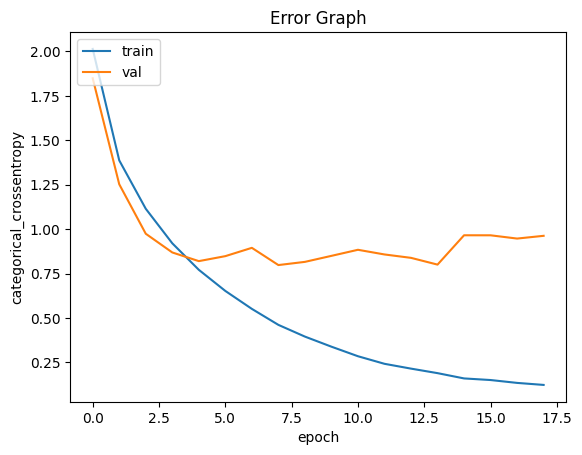

In [ ]:
plot_losses(history, loss)

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.8422279357910156
Test accuracy: 0.7459999918937683


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


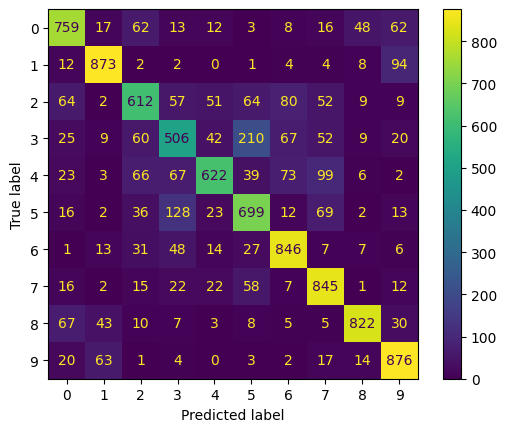

In [ ]:
y_pred = model.predict(x_test)

plot_cm(y_pred, y_test)

In [ ]:
target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5', 'class 6', 'class 7', 'class 8', 'class 9']

print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.76      0.76      0.76      1000
     class 1       0.85      0.87      0.86      1000
     class 2       0.68      0.61      0.65      1000
     class 3       0.59      0.51      0.55      1000
     class 4       0.79      0.62      0.70      1000
     class 5       0.63      0.70      0.66      1000
     class 6       0.77      0.85      0.80      1000
     class 7       0.72      0.84      0.78      1000
     class 8       0.89      0.82      0.85      1000
     class 9       0.78      0.88      0.82      1000

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.74     10000
weighted avg       0.75      0.75      0.74     10000



Ahora ya tenemos resultados aceptables, pero esta no es la única forma de mejorar nuestro modelo, si ya conocemos alguna arquitectura del estado del arte para nuestra tarea podemos simplemente importar un modelo, congelarlo y reemplazar la última capa para que se ajuste a nuestro problema. Esto se llama `Transfer Learning` y es una de las formas más usadas para entrenar redes neuronales en la actualidad, ya que nos ahorra mucho tiempo de entrenamiento y nos permite usar modelos que ya han sido probados y que sabemos que funcionan bien.

### 1.2.4 Transfer Learning

In [ ]:
pre_trained_mobilenet = keras.applications.VGG16(input_shape=input_shape,include_top=False) #Cargamos la red pre-entrenada, sin la capa densa final, ya que queremos adaptar esta red a nuestro dataset.

#Agregamos una capa de GlobalAveragePooling2D para reducir la dimensionalidad de la salida de la red pre-entrenada y la capa de salida.
x = pre_trained_mobilenet.output
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs=pre_trained_mobilenet.input, outputs=outputs)

for layer in pre_trained_mobilenet.layers: #Tenemos que explicitar que no queremos entrenar las capas de la red pre-entrenada.
    layer.trainable = False

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 32, 32, 3)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)        │      1,792 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)        │     36,928 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)        │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)       │     73,856 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)       │    147,584 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)         │    295,168 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)         │    590,080 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)         │    590,080 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)         │  1,180,160 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)         │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)         │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)         │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)         │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)         │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ global_average_pooling2d        │ (None, 512)               │          0 │
│ (GlobalAveragePooling2D)        │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_16 (Dense)                │ (None, 10)                │      5,130 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 14,719,818 (56.15 MB)

 Trainable params: 5,130 (20.04 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

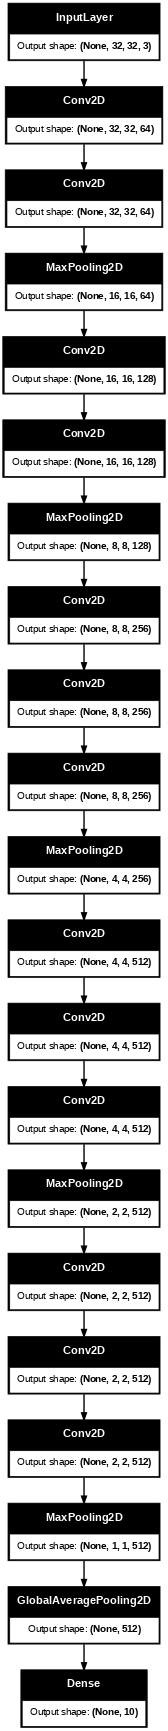

In [ ]:
keras.utils.plot_model(model, show_shapes=True, rankdir="TB", dpi=50)

In [ ]:
#Cambiamos el Optimizador
loss= keras.losses.CategoricalCrossentropy()
optimizer= keras.optimizers.AdamW(learning_rate=1e-3)
metrics=["accuracy"]

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [ ]:
#Entrenamos nuestro modelo
history = model.fit(x_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=validation_split,
                    verbose=1,
                    callbacks=my_callbacks
                    )

Epoch 1/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - accuracy: 0.2907 - loss: 2.0249 - val_accuracy: 0.4853 - val_loss: 1.5376
Epoch 2/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.5002 - loss: 1.4875 - val_accuracy: 0.5189 - val_loss: 1.4136
Epoch 3/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.5312 - loss: 1.3800 - val_accuracy: 0.5375 - val_loss: 1.3556
Epoch 4/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.5509 - loss: 1.3241 - val_accuracy: 0.5481 - val_loss: 1.3198
Epoch 5/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.5632 - loss: 1.2874 - val_accuracy: 0.5561 - val_loss: 1.2950
Epoch 6/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.5717 - loss: 1.2607 - val_accuracy: 0.5617 - val_loss: 1.2768
Epoch 7/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.5779 - loss: 1.2400 - val_accuracy: 0.5663 - val_loss: 1.2627
Epoch 8/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.5832 - loss: 1.2235

KeyboardInterrupt: ignored

In [ ]:
plot_losses(history, loss)

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

In [ ]:
y_pred = model.predict(x_test)

plot_cm(y_pred, y_test)

In [ ]:
target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5', 'class 6', 'class 7', 'class 8', 'class 9']

print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), target_names=target_names))

Podemos observar cómo no obtenemos resultados tan buenos como la red anterior pero hay que tener en cuenta que implementamos una arquitectura en menos de 5 lineas, desde cargar el modelo, agregar una capa de max pooling y finalmente la capa de salida.

## Parte 2: Datset Guiado

### 2.1 Exploracion de la Data

In [ ]:
df = pd.read_csv('Steel_industry_data.csv')

In [ ]:
df.head()

Siempre es bueno revisar los datos que tenemos, ver si existen datos faltantes, el tipo de dato de cada columna, etc.

In [ ]:
df.info()

**Realice un pequeño EDA (Exploratory Data Analisys) del Dataset, mostrando algunos gráficos como el que se presenta a continuación, y comente lo que observa. [3pts]**

In [ ]:
sns.pairplot(df, hue='Load_Type')

Error in callback <function _draw_all_if_interactive at 0x78c23cfe1630> (for post_execute):


KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x78c23cfe08b0> (for post_execute):


KeyboardInterrupt: ignored

A continuación realizamos un histograma para ver el comportamiento de las variables númericas:

array([[<Axes: title={'center': 'Usage_kWh'}>,
        <Axes: title={'center': 'Lagging_Current_Reactive.Power_kVarh'}>,
        <Axes: title={'center': 'Leading_Current_Reactive_Power_kVarh'}>],
       [<Axes: title={'center': 'CO2(tCO2)'}>,
        <Axes: title={'center': 'Lagging_Current_Power_Factor'}>,
        <Axes: title={'center': 'Leading_Current_Power_Factor'}>],
       [<Axes: title={'center': 'NSM'}>, <Axes: >, <Axes: >]],
      dtype=object)

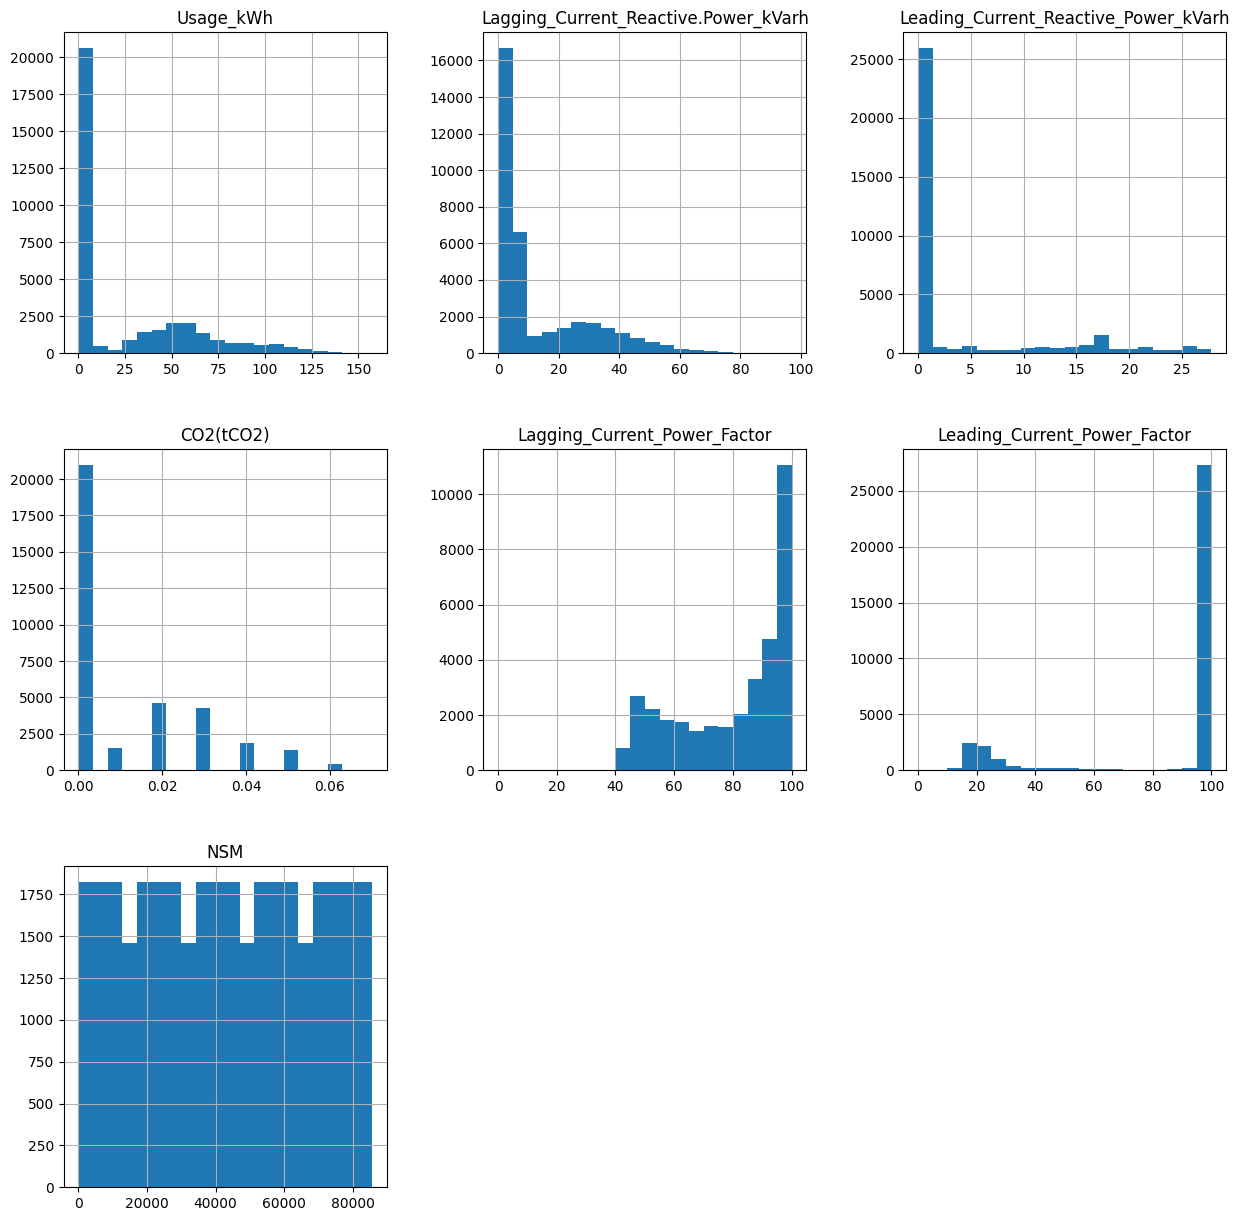

In [ ]:
df.hist(figsize=(15,15), bins=20)


- Con las variables: _Leading Current Reactive.Power kVarh_, _CO2(tCO2)_, _Usage kWh_, _Lagging Current Reactive.Power kVarh_  podemos apreciar que la mayor cantidad de valores se encuentra hacia la izquierda del gráfico con valores cercanos a 0.
- Para las variables: _Lagging Current Reactive.Power_ y _Leading Current Reactive.Power_ ocurre los contrario de los casos anteriores y la mayor cantidad de valores se encuentra hacia la derecha con valores cercanos a 100.
- Finalmente la variable _NSM_ parece tener una cantidad de valores uniformes, salvo por pequeños baches del gráfico.



A continuación realizamos un histograma para ver la comparación entre las variables categóricas:

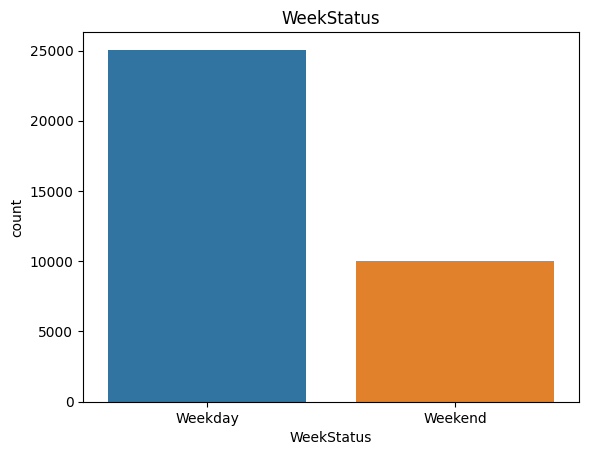

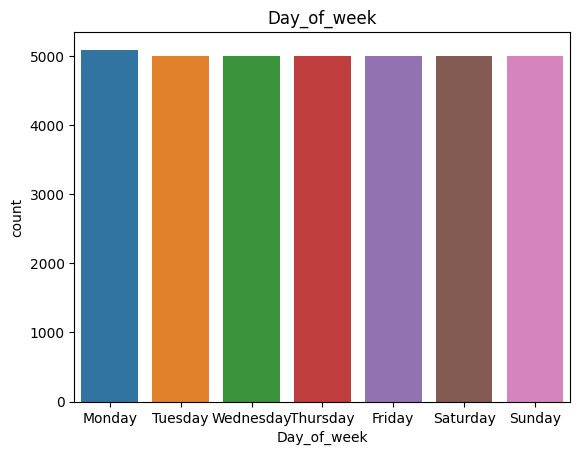

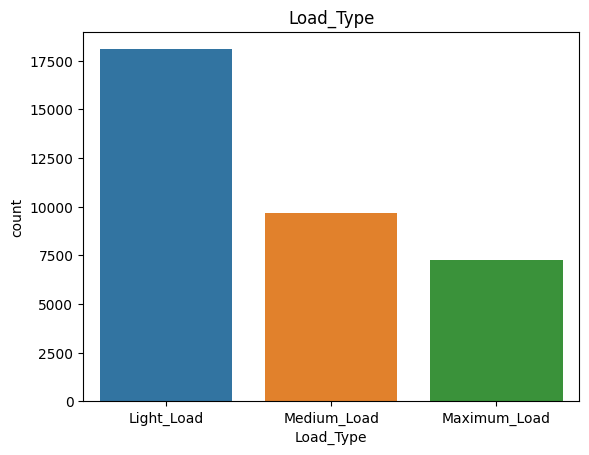

In [ ]:
features = df[['WeekStatus', 'Day_of_week', 'Load_Type']]

for i in features:
    ax = sns.countplot(data=features, x=i)
    plt.title(i)
    plt.show()

- De la variable WeekStatus podemos observar que se encuentra desbalanceada y que la categoría _Weekday_ supera por más del doble la categoría _Weekend_.
- Podemos observar que la variable _Day of Week_ se encuentra balanceada.
- La variable categórica _Load Type_ también se encuentra desbalanceada y hay  una mayor cantidad de datos del tipo _Light Load_.

Usage_kWh                                  Axes(0.125,0.11;0.0945122x0.77)
Lagging_Current_Reactive.Power_kVarh    Axes(0.238415,0.11;0.0945122x0.77)
Leading_Current_Reactive_Power_kVarh    Axes(0.351829,0.11;0.0945122x0.77)
CO2(tCO2)                               Axes(0.465244,0.11;0.0945122x0.77)
Lagging_Current_Power_Factor            Axes(0.578659,0.11;0.0945122x0.77)
Leading_Current_Power_Factor            Axes(0.692073,0.11;0.0945122x0.77)
NSM                                     Axes(0.805488,0.11;0.0945122x0.77)
dtype: object

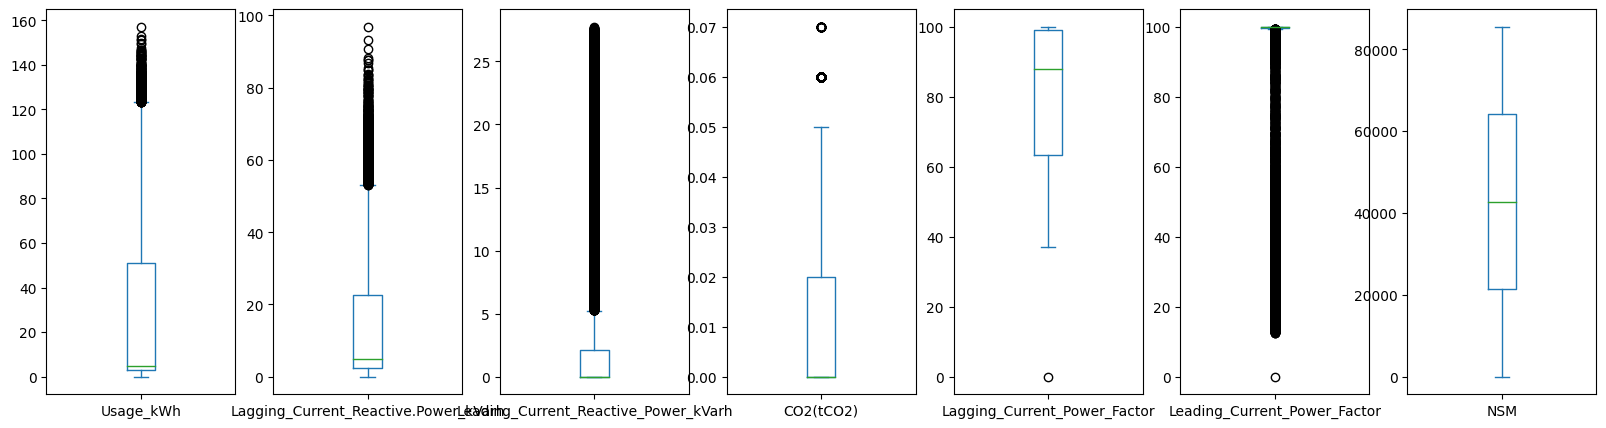

In [ ]:
df.plot(kind="box",subplots=True,layout=(1,7),figsize=(20,5))

- Del grafico se puede observar que las variables que tienen una mayor cantidad del valores atípicos es: _Leading Current Power Factor Kvarh_ y _Leading Current Power Factor_

- _Usage kWh_ y _Lagging Current Reactive.Power kVarh_ tienen una menor cantidad de valores atípicos en comparación a los anteriores.

- Las variables que tienen una menor cantidad de valores atípicos son: _CO2(tCO2)_, _Lagging Current Power Factor_ y _NSM_. Este último no contiene valores atípicos.



<ipython-input-8-37c61b855025>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data_corr= df.corr()


<Axes: >

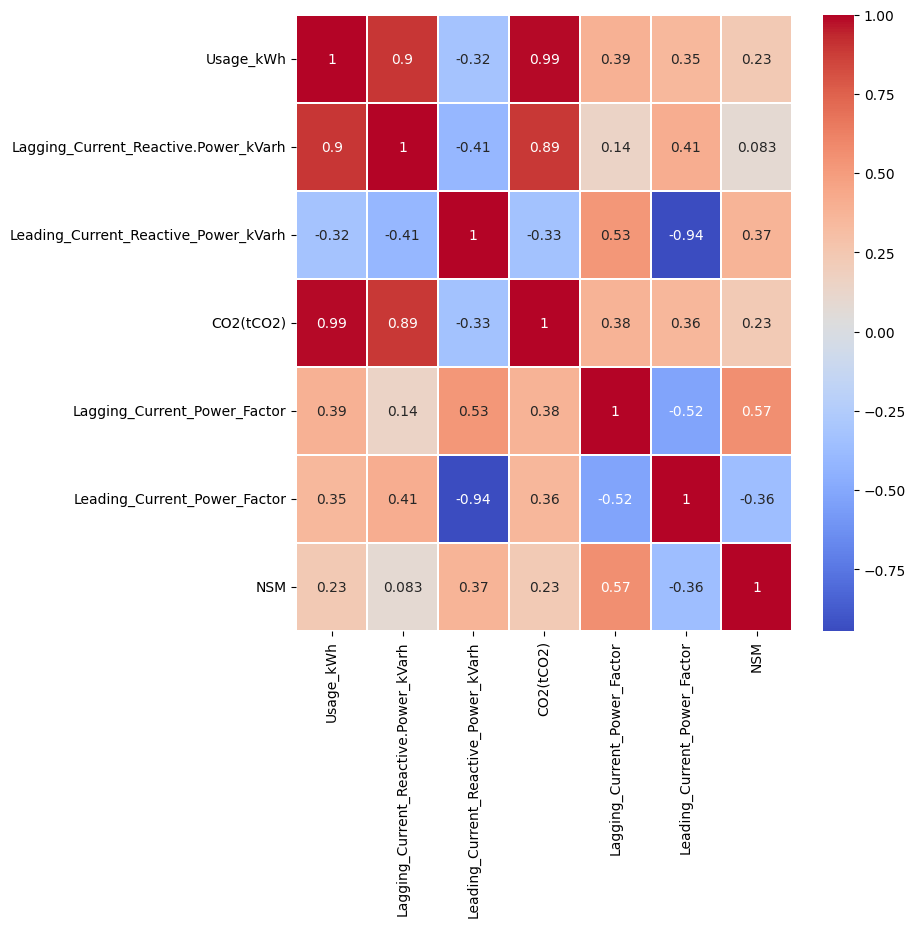

In [ ]:
data_corr= df.corr()
plt.figure(figsize=(8,8))

sns.heatmap(data_corr, cmap='coolwarm', linewidths=0.1, annot=True, linecolor='white')

- Del gráfico podemos observar una alta correlación de la variable _Usage kWh_ con las variables: _CO2(tCO2)_ y _Lagging Current Reactive.Power kVarh_, lo cual se debe a que una mayor cantidad de uso de energia esta relacionado a una mayor cantidad de emisiones de CO2 y mediciones de corrientes.
- Otro resultado importante es la fuerte relación inversamente proporcional entre las variables: _Leading Current Reactive.Power kVarh_ y _Leading Current Reactive.Power_.

### 2.2 Preprocesamiento

El proceso típico de entrenamiento de un modelo consta de dividir la data en 3 conjuntos, uno para entrenamiento, otro para validación y otro para testing

**Defina cuál es la utilidad de cada uno de estos conjuntos e implemente el código para separar la data considerando un split de 80/10/10 respectivamente** [3 Pts]

*   `Training`: Conjunto de datos utilizados en el proceso de aprendizaje para entrenar el modelo.
*   `Validation`: Conjunto de datos utilizados posteriormente al entramiento del modelo, para evaluar su comportamiento y ajustar diferentes hiperparámetros.
*   `Testing`: Conjunto de datos que se utiliza para medir el rendimiento del
modelo entrenado. Estos datos no se utilizan durante el entrenamiento del modelo y se mantienen completamente independientes

*80% de la data para entrenamiento, 10% para validación y el 10% para testing*

*Para ello se puede apoyar en la función [train_test_split](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html) de scikit-learn.*

```
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size="size_for_test", random_state=SEED)
```
```
# Using a pandas dataframe
df_train, df_test = train_test_split(df_data, test_size="size_for_test", random_state=SEED)
```

In [ ]:
# Dividir la data considerando el split indicado anteriormente (se recomienda separar en train y test en esta sección, y separar en validación en la sección de entrenamiento)
### START CODE HERE ###
from sklearn.model_selection import train_test_split
X = df.drop('Usage_kWh',axis=1)
y = df['Usage_kWh']
X_train, x_test, Y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
X_test, X_val, Y_test, Y_val = train_test_split(x_test, y_test, test_size=0.5)

In [ ]:
print("X_train:",X_train.shape)
print("Y_train:",Y_train.shape)
print("X_test:",X_test.shape)
print("Y_test:",Y_test.shape)
print("X_val:",X_val.shape)
print("Y_val:",Y_val.shape)

### 2.3 Feature Engineering

Feature Engineering se considera un arte porque involucra mucho la creatividad con el conocimiento del dominio del problema. Consiste en el proceso de crear nuevas características o features a partir de otras existentes. En general la idea principal es la de utilizar el conocimiento del contexto del problema o bien del dominio de los datos para aprovechar esa información y crear features que puedan ayudar en el desempeño de un algoritmo, si bien existen técnicas más o menos estándar como lo puede ser normalizar o estandarizar valores numéricos tambien existen otras transformaciones que no son tan simples y varían mucho dependiendo del problema.

[Referencia](https://elitedatascience.com/feature-engineering)

#### Standard Techniques

Como se ha mencionado anteriormente existen técnicas bastante conocidas en la actualidad para abordar el apartado de Feature Engineer donde la mayoría de estas se pueden dividir en dos grandes grupos dependiendo del tipo de datos tengamos:

1.   Variables numéricas

  - Usage_kWh                       
  - Lagging_Current_Reactive.Power_kVarh
  - CO2(tCO2)                            
  - Lagging_Current_Power_Factor      
  - Leading_Current_Power_Factor         
  - NSM

2.   Variables categóricas

  - date  
  - WeekStatus    
  - Day_of_week  
  - Load_Type   
  
#### Numerical values

*   Normalizing: `MinMaxScaler `
*   Standarizing: `StandardScaler`

#### Categorical values

*   `One-Hot Encoding.`
*   `Ordinal Encoding.`
*   `Label Encoding.`





**Observe el siguiente código y comente cuál podría ser su utilidad para una variable relacionada con fechas, como lo puede ser un día** [2 Pts]

Estas variables relacionadas a fechas son ciclicas, por tanto se pueden representar su valor dentro de una circunferencia con el seno y coseno. La ventaja es que solo necesitamos dos columnas para representar todos los valores de esa feature, lo cual simplifica bastante en comparacion a utilizar otra codificación como one hot encoding.

In [ ]:
def preprocess_time(df, column, period):
    df['sin_'+column] = np.sin(2 * np.pi * df[column] / period)
    df['cos_'+column] = np.cos(2 * np.pi * df[column] / period)
    df.drop([column], axis=1, inplace=True)
    return df

In [ ]:
# Crear un dataframe de muestra y aplicar la función
df_day = pd.DataFrame(data=np.arange(1, 366), columns=["day"])
df_day = preprocess_time(df_day, "day", 365)
df_day.head()

In [ ]:
# Mostrar la transformación aplicada
fig = plt.figure(figsize=(8, 6))

sns.scatterplot(data=df_day, x="sin_day", y="cos_day").set_title("Encoding utilizado")

plt.show()

`Respuesta`:

**Defina o explique la transformación que aplica cada uno de los siguientes encoding e indique la diferencia entre ellos considerando sklearn** [3 Pts]




*   `One-Hot Encoding`: Crea una columna binaria para cada valor único que exista en la variable categórica que estamos codificando, y marcar con un 1 la columna correspondiente al valor de cada registro y deja las demás columnas con un valor de 0.
*   `Ordinal Encoding`: Convierte cada etiqueta única a un valor entero en casos donde hay una relación conocida entre las variables.
*   `Label Encoding`: Es una forma de asignar valores numéricos a las diferentes categorías de una variable categórica.

**Aplique las siguientes técnicas de preprocesamiento para cada feature especificado:** [3 Pts]

*   `MinMaxScaler` con rango (0, 1): `CO2(tCO2)`, `NSM`
*   `StandardScaler`: `Lagging_Current_Reactive.Power_kVarh`, `Leading_Current_Reactive_Power_kVarh`, `Lagging_Current_Power_Factor`, `Leading_Current_Power_Factor`
*   `Ordinal Encoding`: `Load_Type`
*   `One-Hot Encoding`: `WeekStatus`
*   `Label Encoding`: `Day_of_week`

In [ ]:
# MinMaxScales
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))

# rango default (0,1)
X_train['CO2(tCO2)'] = scaler.fit_transform(X_train[['CO2(tCO2)']])
X_test['CO2(tCO2)'] = scaler.transform(X_test[['CO2(tCO2)']])
X_val['CO2(tCO2)'] = scaler.transform(X_val[['CO2(tCO2)']])

X_train['NSM'] = scaler.fit_transform(X_train[['NSM']])
X_test['NSM'] = scaler.transform(X_test[['NSM']])
X_val['NSM'] = scaler.transform(X_val[['NSM']])

# StandarScaler
from sklearn import preprocessing
import numpy as np
X_scaler = preprocessing.StandardScaler()

cols_to_normalize = ['Lagging_Current_Reactive.Power_kVarh',
                     'Leading_Current_Reactive_Power_kVarh',
                     'Lagging_Current_Power_Factor',
                     'Leading_Current_Power_Factor']

X_train[cols_to_normalize] = X_scaler.fit_transform(X_train[cols_to_normalize])
X_test[cols_to_normalize] = X_scaler.transform(X_test[cols_to_normalize])
X_val[cols_to_normalize] = X_scaler.transform(X_val[cols_to_normalize])

# Ordinal Encoder
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
X_train['Load_Type'] = enc.fit_transform(np.array(X_train['Load_Type']).reshape(-1, 1))
X_test['Load_Type'] = enc.transform(np.array(X_test['Load_Type']).reshape(-1, 1))
X_val['Load_Type'] = enc.transform(np.array(X_val['Load_Type']).reshape(-1, 1))

# One Hot Encoder
a = pd.get_dummies(X_train['WeekStatus'],prefix='WeekStatus')
b = pd.get_dummies(X_test['WeekStatus'],prefix='WeekStatus')
c = pd.get_dummies(X_val['WeekStatus'],prefix='WeekStatus')
X_train = pd.concat([X_train,a],axis=1)
X_test = pd.concat([X_test,b],axis=1)
X_val = pd.concat([X_val,c],axis=1)

X_train.drop(['WeekStatus'], axis=1, inplace=True)
X_test.drop(['WeekStatus'], axis=1, inplace=True)
X_val.drop(['WeekStatus'], axis=1, inplace=True)

# Label Encoder
le = preprocessing.LabelEncoder()

X_train["Day_of_week"] = le.fit_transform(X_train["Day_of_week"])
X_test["Day_of_week"] = le.transform(X_test["Day_of_week"])
X_val["Day_of_week"] = le.transform(X_val["Day_of_week"])

Por último separe en `dia`, `mes` y `hora` la columna `date` y aplique la transformación cíclica a las nuevas columnas (con el periodo correspondiente para cada una).

In [ ]:
# variables de train
date_train = pd.to_datetime(X_train['date'], format='%d/%m/%Y %H:%M')
X_train['day of week'] = date_train.dt.dayofweek
X_train['month'] = date_train.dt.month
X_train['year'] = date_train.dt.year
X_train['hour'] = date_train.dt.hour
X_train['day'] = date_train.dt.day

# variables de test
date_test = pd.to_datetime(X_test['date'], format='%d/%m/%Y %H:%M')
X_test['day of week'] = date_test.dt.dayofweek
X_test['month'] = date_test.dt.month
X_test['year'] = date_test.dt.year
X_test['hour'] = date_test.dt.hour
X_test['day'] = date_test.dt.day

# variables de val
date_val = pd.to_datetime(X_val['date'], format='%d/%m/%Y %H:%M')
X_val['day of week'] = date_val.dt.dayofweek
X_val['month'] = date_val.dt.month
X_val['year'] = date_val.dt.year
X_val['hour'] = date_val.dt.hour
X_val['day'] = date_val.dt.day

# train conversion
X_train_day_of_week = preprocess_time(X_train, "day of week", 7)
X_train_day = preprocess_time(X_train, "day", 30)
X_train_month = preprocess_time(X_train, "month", 12)
X_train_hour = preprocess_time(X_train, "hour", 24)

# test conversion
X_test_day_of_week = preprocess_time(X_test, "day of week", 7)
X_test_day = preprocess_time(X_test, "day", 30)
X_test_month = preprocess_time(X_test, "month", 12)
X_test_hour = preprocess_time(X_test, "hour", 24)

# val conversion
X_val_day_of_week = preprocess_time(X_val, "day of week", 7)
X_val_day = preprocess_time(X_val, "day", 30)
X_val_month = preprocess_time(X_val, "month", 12)
X_val_hour = preprocess_time(X_val, "hour", 24)

# drop date
X_train.drop(['date'], axis=1, inplace=True)
X_test.drop(['date'], axis=1, inplace=True)
X_val.drop(['date'], axis=1, inplace=True)

X_train.drop(['Day_of_week'], axis=1, inplace=True)
X_test.drop(['Day_of_week'], axis=1, inplace=True)
X_val.drop(['Day_of_week'], axis=1, inplace=True)

In [ ]:
X_train.head()

### 2.4 Datos a predecir

Una vez teniendo nuestro dataset preprocesado toca crear un modelo de redes neuronales para predecir, para esto vamos a separar nuestro vector de entrada de la columna a predecir.

<strong> Los datos fueron separados al inicio de esta sección. </strong>

### 2.5 Mi primera Red Neuronal

Ahora procederemos a crear nuestro modelo con Keras, aca queda a libre elección si quieren utilizar la API secuencial o funcional, y tambien queda a libre elección la arquitectura de la red, pruebe con distintas capas, distinto número de neuronas, distintas funciones de activación, regularizadores, etc.

In [ ]:
#Crear un modelo de Keras a libre elección
### START CODE HERE ###
inputs = keras.layers.Input(shape=(X_train.shape[1],))
x = keras.layers.Dense(512,activation='relu')(inputs)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Dense(256,activation='relu')(inputs)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Dense(128,activation='relu')(x)
x = keras.layers.Dropout(0.1)(x)
output = keras.layers.Dense(1,activation='linear')(x)
model = keras.Model(inputs=inputs, outputs=output)
model.summary()

**Siendo un problema de regresión, ¿cuántas neuronas en la capa de salida tiene que tener nuestro modelo? y con que activación? [3pts]**

`Respuesta`: Considerando que el target _Usage\_kWh_ solo tiene valores continuos positivos y es un problema de regresión, entonces utilizamos una capa de salida y la función de activación "Relu" o "Lineal".

Ahora vamos a compilar y entrenar nuestro modelo, si quiere ponerse más creativo en esta sección puede implementar callbacks, probar distintos optimizadores, batch_size y epochs.

In [ ]:
### START CODE HERE ###
epochs = 200
batch_size = 128
my_callbacks = [
    keras.callbacks.EarlyStopping(
      monitor="val_loss",
      min_delta=0,
      patience=40,
      restore_best_weights=True #Es importante retornar los mejores pesos, por defecto viene en False asi que siempre asegurarse de ponerlo en True
    )
] #si va a implementar early stopping, asegurese de retornar los mejores pesos

In [ ]:
### START CODE HERE ###
loss = keras.losses.MeanSquaredError()
opt = keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=opt, loss=loss, metrics=["mean_squared_error", "mean_absolute_error", "root_mean_squared_error"])

### 2.6 Entrenando el Modelo

In [ ]:
### START CODE HERE ###
history = model.fit(X_train,
                    Y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val,Y_val),
                    callbacks=my_callbacks,
                    verbose=1)

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = model.predict(X_test)

mse = mean_squared_error(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Crear una figura
plt.figure(figsize=(7, 6))

# Graficar los datos reales en azul
plt.scatter(Y_test, y_pred, color='blue', label='Datos reales vs. Predicciones')

# Graficar la línea de regresión (identidad) en rojo
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], color='red', linestyle='--', linewidth=2, label='Línea de Regresión')

# Etiquetas de ejes y leyenda
plt.xlabel('Valores Test')
plt.ylabel('Valores Predichos')
plt.legend()

# Título del gráfico
plt.title('Gráfico de Regresión Lineal')

# Mostrar el gráfico
plt.show()

In [ ]:
plot_losses(history, loss)

In [ ]:
score = model.evaluate(X_test, Y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

### 2.7 Exportar y guardar el Modelo

Por último, una vez entrenado nuestro modelo es importante guardarlo, para esto utilizaremos la función `save_model` de keras

In [ ]:
model.save('steel_ind_regression.keras')

Para la entrega de la tarea, el modelo creado tiene que ser subido junto al jupyter notebook completado al github, ya sea en .keras o en un archivo .zip, el modelo será cargado y evaluado para comprobar su correcto funcionamiento, se recomienda probar el guardar y cargar el modelo en el mismo notebook para verificar que no hayan errores.